In [1]:
import cv2
import time 
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_path = "/home/sid-pc/ashutosh/DDP/NYU Dataset and Toolbox/nyu_depth_v2_labeled.mat"

img_resize_X = 320
img_resize_Y = 240

depth_resize_X = 80
depth_resize_Y = 60

In [3]:
t1 = time.time()

In [4]:
f = h5py.File(data_path)

In [5]:
# HxWxN matrix of in-painted depth maps where H and W are the height and width, 
# respectively and N is the number of images. The values of the depth elements are in meters.
depths = f['depths']
depths = np.einsum('ijk->ikj',depths)

#HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.   
# 3 * 640 * 480
imgs = f['images']
imgs = np.einsum('ijkl->ilkj',imgs)

# HxWxN matrix of instance maps
instances = f['instances']
instances = np.einsum('ijk->ikj',instances)

# HxWxN matrix of object label masks where H and W are the height and width, respectively and N is the number of images.
# The labels range from 1..C where C is the total number of classes.
# If a pixel’s label value is 0, then that pixel is ‘unlabeled’.
lbls = f['labels']
lbls = np.einsum('ijk->ikj',lbls)

# Cx1 cell array of the english names of each class.
names = np.array(f['names'])

# map from english label names to class IDs (with C key-value pairs)
names_to_ids = np.array(f['namesToIds'])

# HxWxN matrix of raw depth maps where H and W are the height and width, respectively, and N is the number of images. 
# These depth maps capture the depth images after they have been projected onto the RGB image plane but 
# before the missing depth values have been filled in.
# Additionally, the depth non-linearity from the Kinect device has been removed and the values of each depth image are in meters
raw_depths = f['rawDepths']
raw_depths = np.einsum('ijk->ikj',raw_depths)

# Nx1 cell array of the type of the scene from which each image was taken
scenceTypes = f['sceneTypes']

# Nx1 cell array of the name of the scene from which each image was taken
scenes = f['scenes']


In [6]:
max_depth = np.amax(depths)
min_depth = np.amin(depths)
print "minimum depth {} m \nmaximum depth {} m".format(min_depth, max_depth)
print "Range of values of class labels ({},{})".format(np.amin(lbls), np.amax(lbls))

minimum depth 0.713299512863 m 
maximum depth 9.995470047 m
Range of values of class labels (0,894)


In [7]:
scale_depths = np.divide((depths - min_depth) , (max_depth - min_depth))

In [8]:
depths_resized = []
for i in tqdm(range(depths.shape[0])) :
     depths_resized.append(cv2.resize(scale_depths[i], (depth_resize_X, depth_resize_Y), interpolation = cv2.INTER_AREA))
depths_resized = np.array(depths_resized)

100%|██████████| 1449/1449 [00:00<00:00, 1794.52it/s]


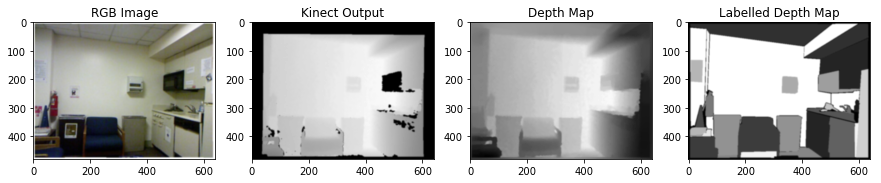

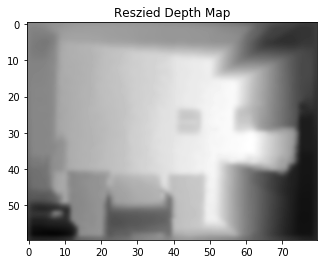

In [9]:
plt.figure(figsize=(15,30))
plt.subplot(1,4,1)
plt.title("RGB Image")
plt.imshow(imgs[0], cmap = 'gray', interpolation = 'bicubic')
plt.subplot(1,4,2)
plt.title("Kinect Output")
plt.imshow(raw_depths[0], cmap = 'gray', interpolation = 'bicubic')
plt.subplot(1,4,3)
plt.title("Depth Map")
plt.imshow(depths[0], cmap = 'gray', interpolation = 'bicubic')
plt.subplot(1,4,4)
plt.title("Labelled Depth Map")
plt.imshow(lbls[0], cmap = 'gray', interpolation = 'bicubic')
plt.show()
plt.title("Reszied Depth Map")
plt.imshow(depths_resized[0], cmap = 'gray', interpolation = 'bicubic')
plt.show()

In [10]:
imgs_resized = []
for i in tqdm(range(depths.shape[0])) :
    imgs_resized.append(cv2.resize(imgs[i], (img_resize_X , img_resize_Y), interpolation = cv2.INTER_AREA))
imgs_resized = np.array(imgs_resized)

100%|██████████| 1449/1449 [00:02<00:00, 647.95it/s]


In [11]:
scale_imgs = np.divide(imgs_resized , 255.0)

In [12]:
X = scale_imgs
y = []
for i in tqdm(range(depths.shape[0])) :
    y.append(depths_resized[i].flatten())
y = np.array(y)

100%|██████████| 1449/1449 [00:00<00:00, 213554.46it/s]


In [13]:
np.save('train_X_{}_{}'.format(img_resize_Y , img_resize_X ) , X)
np.save('train_Y_{}_{}'.format(depth_resize_Y , depth_resize_X), y)

In [14]:
t2 = time.time()
print "Preprocessing time is {} minute".format((t2-t1)/60)

Preprocessing time is 1.27457505067 minute
